# Group H S2 - Twitter Crypto Analytics

Members: 
Quirijn Bolhuis, Paloma Van Ginderachter, Orlando Montalvo, 
Mikael Dzhaneryan, Martina Cilia, Youssef Zourob, Thomas Stenger

<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

<img width="200" style="float:left" 
     src="https://hadoop.apache.org/hadoop-logo.jpg" />

<img width="200" style="float:left" 
     src="https://nifi.apache.org/assets/images/apache-nifi-logo.svg" />

# Sections
* [Description](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Import required Modules/Libraries](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Raw Data Preparation](#2.)
  * [2.1 Promoting our data from Raw Layer to Std Layer in our Datalake](#2.1)
* [3. Analytics](#3.)
  * [3.1 Tweets Data Overview and General Statistics](#3.1)
  * [3.2 Proportion of devices used for tweeting](#3.2)
  * [3.3 Top 10 Rankings](#3.3)
    * [3.3.1 Top 10 Users Rankings](#3.3.1)
    * [3.3.2 Top 10 Hash/Cashtags & Emojis Rankings](#3.3.2)
  * [3.4 Location Related Information](#3.4)
* [4. Enhanced Analytics](#4.)
  * [4.1 Preparing DF for Retweets Analysis](#4.1)
  * [4.2 Retweeted Users with Most Followers](#4.2)
  * [4.3 Most Retweeted Users](#4.3)
  * [4.4 Most Popular Retweets with Replies](#4.4)
  * [4.5 Retweeters with Most Followers](#4.5)
* [5. Finish Line](#5.)

<a id='0'></a>
## Description

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service as usual.

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Importing required modules/libraries

Importing all required libraries used throughout this project

In [1]:
import findspark
findspark.init()
import pandas as pd
import os
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import emojis

In [2]:
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Creating SparkSession

In [3]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

In [4]:
spark = SparkSession.builder\
.appName("Twitter_Project")\
.config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")\
.config("spark.sql.legacy.timeParserPolicy","LEGACY")\
.config("spark.sql.sources.partitionOverwriteMode","dynamic")\
.enableHiveSupport()\
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2.'></a>
## 2.  Raw Data Preparation  

In [5]:
crypto_raw = spark.read.option("inferSchema","true")\
                       .option("recursiveFileLookup", "true")\
                       .json("hdfs://localhost:9000/datalake/raw/group_project/")


In [6]:
# We change the given schema to make it easier to handle 


schema="""
created_at string,
id bigint,
id_str string,
text string,
source string,
truncated boolean,
in_reply_to_status_id bigint,
in_reply_to_status_id_str string,
in_reply_to_user_id bigint,
in_reply_to_user_id_str string,
in_reply_to_screen_name string,
`user` struct<
            id:bigint,
            id_str:string,
            name:string,
            screen_name:string,
            location:string,
            url:string,
            description:string,
            protected:boolean,
            verified:boolean,
            followers_count:bigint,
            friends_count:bigint,
            listed_count:bigint,
            favourites_count:bigint,
            statuses_count:bigint,
            created_at:string,
            profile_banner_url:string,
            profile_image_url_https:string,
            default_profile:boolean,
            default_profile_image:boolean,
            withheld_in_countries: array<string>,
            withheld_scope:string,
            geo_enabled:boolean
            >,
coordinates struct <
            coordinates:array<float>,
            type:string
            >,
place struct<
            country:string,
            country_code:string,
            full_name:string,
            place_type:string,
            url:string
            >,
quoted_status_id bigint,
quoted_status_id_str string,
is_quote_status boolean,
quoted_status struct<
                id:bigint,
                text:string,
                user:struct<
                        name:string,
                        followers_count:bigint
                        >,
                coordinates:struct <
                        coordinates:array<float>,
                        type:string
                        >,
                place:struct<
                        country:string,
                        country_code:string,
                        full_name:string,
                        place_type:string,
                        url:string
                        >,
                favorite_count:bigint
                >,
quote_count bigint,
reply_count bigint,
retweet_count bigint,
favorite_count bigint,
entities struct<
            user_mentions:array<struct<screen_name:string>>,
            hashtags:array<struct<text:string>>, 
            media:array<struct<expanded_url:string>>, 
            urls:array<struct<expanded_url:string>>, 
            symbols:array<struct<text:string>>
            >,
favorited boolean,
retweeted boolean,
possibly_sensitive boolean,
filter_level string,
lang string
"""
crypto_raw = spark.read.schema(schema)\
                       .option("recursiveFileLookup", "true")\
                       .json("hdfs://localhost:9000/datalake/raw/group_project/")
                       

<a id='2.1'></a>
### 2.1  Promoting our data from Raw Layer to Std Layer in our Datalake

In [7]:
crypto_std = crypto_raw\
             .withColumn("created_at",F.to_timestamp(F.col("created_at"),"EEE MMM dd HH:mm:ss ZZZZZ yyyy"))\
             .withColumn("year",F.year("created_at"))\
             .withColumn("dt",F.to_date("created_at"))
                

In [8]:
# Sticking to same partition model as used in class -  makes sense for partitioning twitter data & project scope
(crypto_std.coalesce(1)
          .write
          .partitionBy("year","dt")
          .mode("overwrite")
          .parquet("hdfs://localhost:9000/datalake/std/twitter/group_project/"))

<a id='3.'></a>
## 3. Analytics 

In [9]:
# reading parquet file containing all our tweets collected at different points in time 

tweets = (spark.read
               .parquet("hdfs://localhost:9000/datalake/std/twitter/group_project/"))

<a id='3.1'></a>
### 3.1  Tweets Data Overview and General Statistics

In [10]:
# Summarizing some basic stats & facts in dfs - this includes: 
# Number of tweets; Total number of distinct users; Average number of words per tweet;
# Maximum and average number of hashtags; Average status count per user 
# The average number of friend count/followings per user; Number of tweets including a link; etc. etc.

amount_tweets = int(tweets.count())

amount_dist_users = int(tweets.select("user.id").distinct().count())

df1 = tweets.select(round(avg(size(split("text", " ")))).alias("avg_words")).toPandas()
avg_num_words = int(df1["avg_words"][0])

df2 = (tweets.select(
            max(size("entities.hashtags")).alias("max"),
            avg(size("entities.hashtags")).alias("average"))).toPandas()
hash_max = int(df2["max"][0])
hash_avg_per_100_tweets = int((df2["average"][0])*100)

df3 = (tweets
          .agg(round(avg("user.statuses_count")).alias("avg_num_tweets_per_user"))).toPandas()
avg_num_tweets_user = int(df3["avg_num_tweets_per_user"][0])

df4 = df = (tweets
          .agg(round(avg("user.friends_count")).alias("avg_followings"))).toPandas()
avg_followings = int(df4["avg_followings"][0])

number_tweets_links = int(tweets.filter(tweets["possibly_sensitive"] == True).count())

number_tweets_replies = int(tweets.filter(tweets["in_reply_to_status_id_str"] != "NaN").count())

df5 = tweets.toPandas()
num_retweets = int(dict(df5[df5["is_quote_status"] != None].count())["quoted_status_id"])

basics1 = [
    {"metric":"total amount tweets", "value": amount_tweets},
    {"metric":"retweets", "value": num_retweets},
    {"metric":"reply tweets", "value": number_tweets_replies}
         ]

basics2 = [
    {"metric":"tweets with links", "value": number_tweets_links},
    {"metric":"max. number hashtags", "value": hash_max},
    {"metric":"avg. number hashtags/100 tweets", "value": hash_avg_per_100_tweets},
    {"metric":"avg. number words/tweet", "value": avg_num_words},
    {"metric":"amount of distinct users", "value": amount_dist_users},    
    {"metric":"avg. number tweets/user", "value": avg_num_tweets_user},
    {"metric":"avg. number followings/user", "value": avg_followings}
         ]

schema4 = StructType([
    StructField('metric', StringType(), False),
    StructField('value', IntegerType(), False)])

df1 = spark.createDataFrame(basics1,schema4).toPandas()

df2 = spark.createDataFrame(basics2,schema4).toPandas()

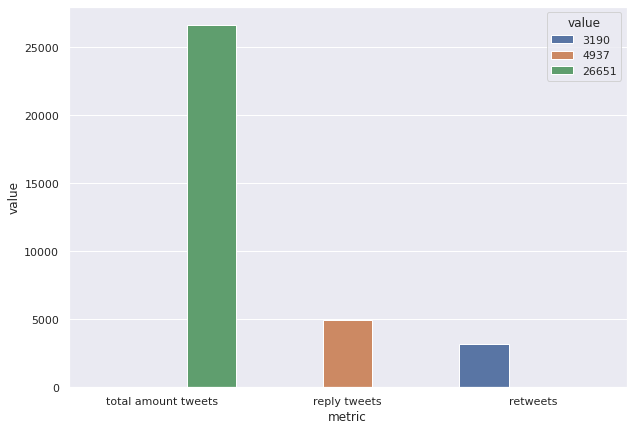

In [11]:
# Graph comparing composition of our tweets (total, replies, retweets)

sns.set(rc={'figure.figsize':(10,7)})
sns.barplot(x="metric", y="value",hue="value", data= df1, order=["total amount tweets","reply tweets","retweets"])
plt.show()

In [12]:
# Quick overview of some basic stats on our tweets

df2

,metric,value
0,tweets with links,147
1,max. number hashtags,17
2,avg. number hashtags/100 tweets,85
3,avg. number words/tweet,19
4,amount of distinct users,17842
5,avg. number tweets/user,11201
6,avg. number followings/user,807


<a id='3.2'></a>
### 3.2  Proportion of devices used for tweeting

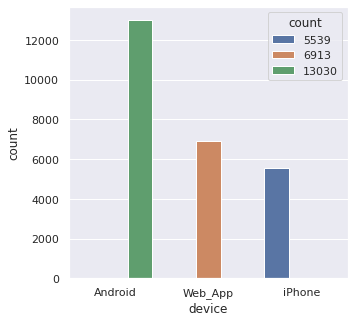

In [38]:
nb_android = tweets.where(tweets.source.like('%Android%')).count()
nb_iphone = tweets.where(tweets.source.like('%iPhone%')).count()
nb_web_app = tweets.where(tweets.source.like('%Web App%')).count()
sources = [{"device":"iPhone", "count": nb_iphone},
          {"device":"Android", "count":nb_android},
          {"device":"Web_App", "count":nb_web_app}]


schema3 = StructType([
    StructField('device', StringType(), False),
    StructField('count', IntegerType(), False)])

df = spark.createDataFrame(sources,schema3)

df = df.toPandas()

sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(x="device", y="count", hue="count",data= df, order=["Android","Web_App","iPhone"])
plt.show()

<a id='3.3'></a>
### 3.3 Top 10 Rankings

In [14]:
# preparing more dfs to get a better understanding of some basic top 10 rankings

#Top 10 users with most tweets posted

top1 = (tweets
          .groupBy("user.screen_name")
          .agg(max("user.statuses_count").alias("tweets_posted"))
          .orderBy(desc("tweets_posted"))
          .limit(10)).toPandas()

#Top 10 users with most followers

top2 = (tweets
          .groupBy("user.screen_name")
          .agg(max("user.followers_count").alias("followers_count"))
          .orderBy(desc("followers_count"))
          .limit(10)).toPandas()

#Top 10 users with most mentions

top3 = (tweets
          .select(explode("entities.user_mentions.screen_name").alias("user"))
          .groupBy(lower("user"))
          .agg(count("*").alias("mentions"))
          .orderBy(desc("mentions"))
          .limit(10)).toPandas()

#Top 10 most popular hashtags

top4 = (tweets
      .select(explode("entities.hashtags.text").alias("hashtag"))
      .groupBy("hashtag")
      .agg(count("*").alias("total"))
      .orderBy(desc("total"))
      .limit(10)).toPandas()

#Top 10 most popular cashtags

top5 = (tweets
    .select(explode("entities.symbols.text").alias("cashtag"))
    .groupBy(upper("cashtag").alias("cashtag"))
    .agg(count("*").alias("total"))\
    .orderBy(desc("total"))
    .limit(10)).toPandas()

#Top 10 emojis

@udf("array<string>")
def get_emojis_udf(s):
    set = emojis.get(s)
    return [*set, ]

top6 = tweets.select(explode(get_emojis_udf("text")).alias("emoji"))\
      .groupBy("emoji").agg(count("*").alias("total")).orderBy(desc("total")).limit(10)\
      .toPandas()

<a id='3.3.1'></a>
#### 3.3.1 Top 10 Users Rankings

In [15]:
# concating all top 10 users ranking dfs for better overview

pd.concat([top1,top2,top3], keys = ["Users Ranking Tweets",
                                    "Users Ranking Followers",
                                    "Users Ranking Mentions",
                                      ], axis = 1)

Users Ranking Tweets               Users Ranking Followers                  \
           screen_name tweets_posted             screen_name followers_count   
0             sectest9       2529190         luciano_eltirri         1286211   
1      CryptoTraderPro       2369039          Emma__Beaumont         1017236   
2       cybersec_feeds       1981033         davidgokhshtein          541524   
3      bmurphypointman       1486224         REALDIEGOVALDEZ          508826   
4              xaelbot       1381323             WazirXIndia          460949   
5         codedailybot       1288831          geoff_deweaver          366547   
6         bitcoinagile       1210841              RealVision          299929   
7          69NiceBot69       1170153              TechDev_52          283071   
8      TheDeveloperBot       1075768             CashBro_303          257714   
9         newsfilterio        926410            SafeMoonRich          217829   

  Users Ranking Mentions           
             lower(user) mentions  
0                binance      840  
1          airdropstario      602  
2         airdropinspect      418  
3             cz_binance      401  
4         cryptocopycats      309  
5               fegtoken      305  
6             lifeisdefi      301  
7               elonmusk      298  
8          safemoneybsc_      258  
9             airdropdet      249

<a id='3.3.2'></a>
#### 3.3.2 Top 10 Hast/Cashtags & Emojis Rankings

In [16]:
# concating all top 10 hash/cashtags & emojis ranking dfs for better overview

pd.concat([top4,top5,top6], keys = ["Ranking Hashtags",
                                    "Ranking Cashtags",
                                    "Ranking Emojis"
                              ], axis = 1)

Ranking Hashtags       Ranking Cashtags       Ranking Emojis      
           hashtag total          cashtag total          emoji total
0              NFT  1081              ETH  1246              🚀  2224
1          Bitcoin  1077             SHIB  1052              ✅  1961
2              ETH  1025              BNB   947              🔥  1505
3              BNB   675              BTC   401             ❤️  1325
4      NFTGiveaway   557              SOL   328              🎁  1288
5             NFTs   517             BUSD   206              🏆  1277
6         Ethereum   511               TT   198              📌   914
7              BTC   493             MGAS   170              🎉   892
8          Airdrop   466             DOGE   162              🚨   783
9             SHIB   435              ADA   144              💸   715

<a id='3.4'></a>
### 3.4 Location Related Information

In [39]:
location = (tweets.select("place.country_code",'place.country').filter(tweets['place.country_code'] != '').
                    groupby('country_code','country').
                    agg(count("*").alias("count")).orderBy(desc("count")).limit(5))

location_df = location.toPandas()
location_df

,country_code,country,count
0,US,United States,20
1,NG,Nigeria,6
2,BD,Bangladesh,4
3,DE,Germany,3
4,MY,Malaysia,1


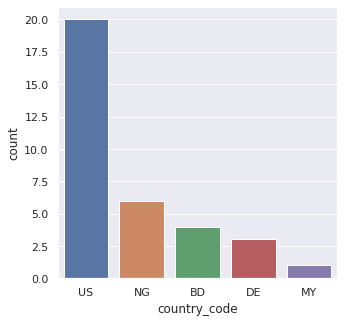

In [40]:
sns.barplot(x='country_code',y='count',data= location_df)
plt.show()

<a id='4.'></a>
## 4. Enhanced Analytics


We want to further analyse our tweets and gauge the overall engagement that these tweets are connected
to on twitter - but how?  
These are all new tweets that were fetched directly by Apache Nifi so we don't have
likes, replies, or retweets for them! 

BUT: We have a field called "quoted_status" in our twitter.json structure - what is this?

quoted_status: This field only surfaces when the Tweet is a quote Tweet/retweet.

This attribute contains the Tweet object of the original Tweet that was quoted/retweeted. \
Including following attributes & sub-attr.: id, text, user, coordinates, place, favorite_count.\
This will allow advanced questions - i.e. most popular retweeted user by followers, most popular retweeted
user by amount of retweets, tweets replying to most popular users, replies to most liked tweets, etc.\
Amazing - like this we can get a quick overview of the crypto "conversation" 
on twitter and maybe spot a trend early on. 


<a id='4.1'></a>
### 4.1 Preparing DF for Retweets Analysis

In [19]:
# creating dataframe w/ relevant attributes

quoted = tweets.select("id","text","user.name","user.followers_count","quoted_status")

# collecting the quoted table as rows 

quoted_rows = quoted.collect()

# I'm having trouble using spark to filter through quoted_status and being able to 
# effectively selecting those quoted_status=None vs. quoted_status!=None for further evaluation
# So we need to use a work-around which makes code a bit longer but the result works! 
# --> we want to create a new df with only those tweets that are retweets (quoted_tweets)
# like this we can access the relevant attributes from the original tweet object
# given the structure of our rows and the position of quoted_status inside a list we create our condition

retweets_list = []
no_retweets_list = []

for row in quoted_rows:
    cond = list(row)
    if cond[4] != None:
        retweets_list.append(row)
    else:
        no_retweets_list.append(row)

        
# turning our python list into a pandas dataframe

df = pd.DataFrame(retweets_list)

# renaming columns

df = df.set_axis(["id","text","name","followers_count","quoted_tweet_info"], axis = 1, inplace = False)


# we need to adjust the schema so that Spark can adapt the schema correctly

schema2 = """
id bigint,
text string,
name string,
followers_count long,
quoted_tweet_info struct<
                id:bigint,
                text:string,
                user:struct<
                        name:string,
                        followers_count:bigint
                        >,
                coordinates:struct <
                        coordinates:array<float>,
                        type:string
                        >,
                place:struct<
                        country:string,
                        country_code:string,
                        full_name:string,
                        place_type:string,
                        url:string
                        >,
                favorite_count:bigint
                >
"""

# turning pandas df into spark df

spark_df = spark.createDataFrame(df,schema2)

# prepping final master df for easier queries
# renaming some columns for better overview
# creating new columns based on sub-attributes of quoted_status
# dropping all duplicated/unecessary columns 

df_master_queries = spark_df\
    .withColumn("tweet_id",F.expr("id"))\
    .withColumn("tweet",F.expr("text"))\
    .withColumn("user",F.expr("name"))\
    .withColumn("followers",F.expr("followers_count"))\
    .withColumn("retweeted_user",F.expr("quoted_tweet_info.user.name"))\
    .withColumn("re_user_followers",F.expr("quoted_tweet_info.user.followers_count"))\
    .withColumn("re_text",F.expr("quoted_tweet_info.text"))\
    .withColumn("likes",F.expr("quoted_tweet_info.favorite_count"))\
    .withColumn("coordinates",F.expr("quoted_tweet_info.coordinates.coordinates"))\
    .withColumn("country",F.expr("quoted_tweet_info.place.country"))\
    .drop("quoted_tweet_info","id","text","name","followers_count")

<a id='4.2'></a>
### 4.2 Retweeted user with most followers 

In [20]:
df_master_queries.groupBy("retweeted_user")\
        .agg(
            max("re_user_followers").alias("followers"))\
        .sort(col("followers").desc())\
        .toPandas().head(15)

# Cool, looks like Snoop Dogg is in the Crpyto Game as well - and President Biden? 

,retweeted_user,followers
0,Elon Musk,66064185
1,Snoop Dogg,19379238
2,The Wall Street Journal,19259722
3,President Biden,15935719
4,Binance,6507580
5,CZ 🔶 Binance,4470791
6,CNBC,4421185
7,The Hill,4282270
8,Coinbase,4185654
9,Bitcoin,3977693


<a id='4.3'></a>
### 4.3 Most Retweeted User

In [21]:
# might be useful to spot trends early on (i.e. user with relevant content)

df_master_queries.groupBy("retweeted_user")\
        .agg(
            count("*").alias("times_retweeted"),
            max("re_user_followers").alias("followers"))\
        .sort(col("times_retweeted").desc())\
        .toPandas().head(15)

,retweeted_user,times_retweeted,followers
0,AirdropDetective,146,919286
1,Alex Becker 🍊🏆🥇,127,596194
2,Binance NFT,80,34786
3,AirdropStar,53,811809
4,Airdrop Inspector,39,1032270
5,Solanium,39,530609
6,Molly Spiers 🧡,36,24052
7,Journalist Dr Kemi Olunloyo📡,36,311528
8,Metakings | Play to Earn,34,94045
9,SafeMoneyBSC,31,38692


In [22]:
# Now let's see some of the original texts from the most retweeted users 

df_master_queries.groupBy("re_text","retweeted_user")\
                .agg(
                    count("re_text").alias("count_retweeted"))\
                .sort(col("count_retweeted").desc())\
                .toPandas().head(10)

,re_text,retweeted_user,count_retweeted
0,🔍 New #Airdrop: SafeMoneyBSC\n\n💲Reward: Up to 950M SafeMoney (~$38)+250B SafeMoney (~$10K) referral pool\n\n🔴Start the… https://t.co/3pN2mlf9yF,AirdropDetective,139
1,Neo Tokyo full set floor : 71 eth\n\nCrypto Punk floor : 68 eth.\n\nHave. A. Nice. Fucking. Day.,Alex Becker 🍊🏆🥇,127
2,Great gift for 12 hours from now 🚀\n\n📌 Buy $BNFT Min 0.35 $BNB On Pancakeswap\nGet 5 $BNB reward automatically to you… https://t.co/gRM2xz4RdF,Binance NFT,47
3,🚀 @meanfinance Whitelist is LIVE! 🚀\n\nMeanFi brings Crypto and DeFi to everyday banking. You can definitely see Mea… https://t.co/CQ7SUYmknK,Solanium,38
4,Paying for a coffee with #Bitcoin Lightning NFC and a pair of @mtsocks ⚡️🧦\n\nANOTHER WORLD FIRST?!?! 👀 https://t.co/E4c0eei3v1,Molly Spiers 🧡,36
5,"Airdrop #7 for 35,000 Winners!\n\n🎁PRIZE🎁\n500 $CRTS\n35,000 WINNERS\n\n🔊RULES🔊\nFollow &amp; RT \n@cratostoken\nMention 3 peopl… https://t.co/BJOePYYW5A",Cratos,29
6,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",CZ 🔶 Binance,28
7,Legend of Argos $LARG #BSC\n\nTG: https://t.co/J6EY8IdOpU\n\n✔️ KYC Approved by Interpol.defi\n✔️ #Sandbox MMORPG\n\n#P2E… https://t.co/AcksH7Kz33,Legend of Argos,27
8,🎉We are celebrating our MINT DAY!!! 🎉\n🥳So we are giving away!🥳\n\n🏆1st Place- 100 ADA\n🏆2nd &amp; 3rd Place- 1 Wolves NFTS… https://t.co/BgfEd6smr6,Wolf Kingdom NFT | Minting is live! |,26
9,"I heard Ada Ameh was a 14yo teen mom thrown out by her parents, that child died in 2020. Ada keep my children out o… https://t.co/S8WRJP8NDL",Journalist Dr Kemi Olunloyo📡,26


<a id='4.4'></a>
### 4.4 Most popular retweets with replies 

In [23]:
# Basically: how are people replying to these most liked (re)tweets? 
# Clarification - a user retweets another user's tweet and basically "comments" on it with his own tweet
# by extracting both we can look at P2P interaction and see what the "conversation" is all about 

df_master_queries.groupBy("tweet","user","retweeted_user","re_text")\
        .agg(
            max("likes").alias("likes"))\
        .sort(col("likes").desc())\
        .toPandas().head(10)

,tweet,user,retweeted_user,re_text,likes
0,RT @Doge4faithfull: Yes we know.\nThe patient have ALWAYS been highly rewarded for MORE THAN 8 LONG YEARS #DogeFamily💚#Dogefather #Dogearmy…,Doge2Andromeda,Elon Musk,It’s inevitable https://t.co/eBKnQm6QyF,606424
1,RT @LiviamCapital: I question the motive. Only me?,Ben 🇺🇸📈,Elon Musk,Tesla &amp; Bitcoin https://t.co/YSswJmVZhP,496926
2,@BillyM2k @TeslaAIBot https://t.co/jhgZlldvw7\n\nYes pump,BABYDOGE PUMP ELON,Elon Musk,"Baby Doge, doo, doo, doo, doo, doo,\nBaby Doge, doo, doo, doo, doo, doo,\nBaby Doge, doo, doo, doo, doo, doo,\nBaby Doge",278793
3,Great project,DAMILOLA ADENIYI,MUSK METAVERSE OFFICIAL,"• Time: 25 Nov 2021 – 24 Dec 2021\n• Amount: 25,000,000,000,000\n• Price: 0.00000002\n\n🎯Payment: BNB , BUSD (BEP20)… https://t.co/oMEEqKfJZ6",150491
4,RT @BeroNacci: #DOGEorTesla \nAbsloutly #DOGE\nTesla is still a weird car in my country and we don't have a lot of recharge stations! very ha…,HiMy,CZ 🔶 Binance,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",91394
5,RT @BeroNacci: #DOGEorTesla \nAbsloutly #DOGE\nTesla is still a weird car in my country and we don't have a lot of recharge stations! very ha…,PERLI MARTINEZ C,CZ 🔶 Binance,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",91392
6,RT @BeroNacci: #DOGEorTesla \nAbsloutly #DOGE\nTesla is still a weird car in my country and we don't have a lot of recharge stations! very ha…,osvaldo dias,CZ 🔶 Binance,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",91392
7,RT @BeroNacci: #DOGEorTesla \nAbsloutly #DOGE\nTesla is still a weird car in my country and we don't have a lot of recharge stations! very ha…,Reina,CZ 🔶 Binance,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",91384
8,RT @BeroNacci: #DOGEorTesla \nAbsloutly #DOGE\nTesla is still a weird car in my country and we don't have a lot of recharge stations! very ha…,Rebeca,CZ 🔶 Binance,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",91380
9,RT @BeroNacci: #DOGEorTesla \nAbsloutly #DOGE\nTesla is still a weird car in my country and we don't have a lot of recharge stations! very ha…,موراد موراد,CZ 🔶 Binance,"I'm giving away a DOGE Tesla &amp; $50,000 in $DOGE. Which do you want?\n\nTo enter:\n🔸Retweet\n🔸Follow @elonmusk, @binance… https://t.co/qJqU24r4y9",91380


<a id='4.5'></a>
### 4.5 Retweeters with most followers

In [24]:
# So the most followed users that issued a retweet 
# Let's see what these guys are saying in their tweets/retweets

df_master_queries.groupBy("user","tweet")\
        .agg(
            max("followers").alias("followers"))\
        .sort(col("followers").desc())\
        .toPandas().head(10)



,user,tweet,followers
0,Real Vision,Just announced at the #vegastakeover!\n\nCheck it out 👉 https://t.co/BJ4yV5TDVo,299929
1,TechDev,Shout out to @CryptoValerio @clevercrypto7 and others who have posted on similar comparisons,283071
2,Jebus,"@taihodl @Astropin @niff3y @udiWertheimer I love my little parrots.\n\nCheep cheep, keep dancing little birds \n\nhttps://t.co/wzzn9eVtpT",100415
3,Guin 🐧,RT @penguinpromotes: 💵| $5 | ₱240 | 70.000 IDR\n\n— RT / LIKE tweet 👇 + rt this\n\n90 mins.,100158
4,Card₳no 🐂 Dan 🇺🇸 🇯🇵 🇪🇹 🇹🇿 🌑 ADA,"RT @amw7: @KaizenCrypto reached out to me immediately after my tweet yesterday. After I explained what I was seeing, we figured out how his…",96282
5,BUTCHER - #BITCOIN MAXI,THIS IS THE BEST THING I HEARD THESE DAYS! 👇,93631
6,Stonks Trading🚀🚀🚀,RT @GenXdoger: Incredible idea!!!! @RobinhoodComms @RobinhoodApp @vladtenev @christine_hall,92817
7,NITIP MENFESS? CEK LIKES,nctn! ini 1 epoxy fullset sama 2 epoxy only. jadi ada 3 epoxy sticker sama 1 pisi js. tetep nay?,85523
8,XRP_Cro,@korman_ashley Xumm is supported too. Check my guide below\nhttps://t.co/SMm9l0Yvoo,83117
9,"NATΞ R◎TH (🐐,🐐)","Fellow apes, this is a unique opportunity to learn from a gigabrain.",81628


<a id='5.'></a>
# 5. Finish Line

We made it - don't forget to stop all the services & good luck spotting the next crypto trend early on twitter!

<img width="200" style="float:left" 
     src="https://www.beingcrypto.com/wp-content/uploads/2021/09/Crypto-Memes-2021.jpg" />